# Initial CLIP Fine Tuning

In [39]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor
import json

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### To manage the dataset comprising image paths and associated captions.

In [41]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, captions, processor):
        """
        image_paths: List of paths to images
        captions: List of text captions corresponding to each image
        processor: An instance of transformers.CLIPProcessor
        """
        self.image_paths = image_paths
        self.captions = captions
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        
        # Process image and text through the CLIP processor
        inputs = self.processor(text=self.captions[idx], images=image, return_tensors="pt", padding=True, truncation=True)
        
        # Return processed pixel values and input IDs
        return inputs["pixel_values"].squeeze(0), inputs["input_ids"].squeeze(0)

Function to handle the batching of data. It separates pixel values and input IDs (from the tokenizer), pads the input IDs dynamically, and stacks pixel values into a tensor.
A DataLoader is then set up with this function to efficiently create batches of data for training.

In [42]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    # Separate the pixel_values and input_ids
    pixel_values = [item[0] for item in batch]
    input_ids = [item[1] for item in batch]

    # Pad the input_ids dynamically
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)

    # Stack the pixel_values
    pixel_values = torch.stack(pixel_values, dim=0)

    return pixel_values, input_ids_padded

In [45]:
# Respective Paths

json_path = 'meta_data.json'
image_path = 'images/'

In [46]:
input_data = []

with open(json_path, 'r') as f:
    input_data = json.load(f)  # This loads the entire JSON array into input_data

# Now input_data contains all the image data
print(len(input_data))  # Prints the number of entries
print(input_data[0])  # Prints the first entry to verify

704
{'image': '001.jpg', 'image_path': 'images_tinea/001.jpg', 'title': 'tinea type of rash at the beard area on a fair skin'}


In [53]:
image_paths = [f"images/{item['image_path'].rstrip()}" for item in input_data]
captions = [item['title'] for item in input_data]

In [54]:
print(image_paths)

['images/images_tinea/001.jpg', 'images/images_tinea/002.jpg', 'images/images_tinea/003.jpg', 'images/images_tinea/004.jpg', 'images/images_tinea/005.jpg', 'images/images_tinea/006.jpg', 'images/images_tinea/007.jpg', 'images/images_tinea/008.jpg', 'images/images_tinea/009.jpg', 'images/images_tinea/010.jpg', 'images/images_tinea/011.jpg', 'images/images_tinea/012.jpg', 'images/images_tinea/013.jpg', 'images/images_tinea/014.jpg', 'images/images_tinea/015.jpg', 'images/images_tinea/016.jpg', 'images/images_tinea/017.jpg', 'images/images_tinea/018.jpg', 'images/images_tinea/019.jpg', 'images/images_tinea/020.jpg', 'images/images_tinea/021.jpg', 'images/images_tinea/022.jpg', 'images/images_tinea/023.jpg', 'images/images_tinea/024.jpg', 'images/images_tinea/025.jpg', 'images/images_tinea/026.jpg', 'images/images_tinea/027.jpg', 'images/images_tinea/028.jpg', 'images/images_tinea/029.jpg', 'images/images_tinea/030.jpg', 'images/images_tinea/031.jpg', 'images/images_tinea/032.jpg', 'images

### Model Initialization and Training:

In [55]:
# Initialize the CLIP processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create the dataset
dataset = CustomDataset(image_paths=image_paths, captions=captions, processor=processor)

# Create a DataLoader
# Assuming dataset is already defined
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=4, collate_fn=collate_fn)


In [56]:
from transformers import CLIPModel

# Load the model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)  # Transfer model to appropriate device (GPU or CPU)
model.train()  # Set the model to training mode


from tqdm import tqdm
import torch.optim as optim

# Setup optimizer here, if not already defined
optimizer = optim.Adam(model.parameters(), lr=5e-6, betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)  # Example learning rate
loss_fn = torch.nn.CrossEntropyLoss()  # Define your loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for pixel_values, input_ids in tqdm(dataloader):
        optimizer.zero_grad()
        pixel_values, input_ids = pixel_values.to(device), input_ids.to(device)
        
        # Forward pass
        outputs = model(pixel_values=pixel_values, input_ids=input_ids)
        logits_per_image = outputs.logits_per_image  # Image-text similarity logits
        ground_truth = torch.arange(len(pixel_values), device=device)  # Correct indices for image-text alignment
        
        # Calculate loss
        loss = loss_fn(logits_per_image, ground_truth)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 1, Loss: 3.5274691581726074


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

Epoch 1, Loss: 3.972594976425171


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 1, Loss: 3.264003038406372


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 1, Loss: 3.5608599185943604


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 1, Loss: 3.1003406047821045


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 1, Loss: 3.0582611560821533


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 1, Loss: 3.042391777038574
Epoch 1, Loss: 0.7350226044654846


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 2, Loss: 2.8940491676330566


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 2, Loss: 2.9993069171905518


 38%|███▊      | 3/8 [00:02<00:02,  1.67it/s]

Epoch 2, Loss: 2.891141653060913


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 2, Loss: 2.76058292388916


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 2, Loss: 2.7661685943603516


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 2, Loss: 2.618992805480957


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch 2, Loss: 2.7252211570739746
Epoch 2, Loss: 0.20184525847434998


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 3, Loss: 2.474484443664551


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 3, Loss: 2.6069018840789795


 38%|███▊      | 3/8 [00:02<00:02,  1.67it/s]

Epoch 3, Loss: 2.662240982055664


 50%|█████     | 4/8 [00:02<00:02,  1.96it/s]

Epoch 3, Loss: 2.473639965057373


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

Epoch 3, Loss: 2.5819997787475586


 75%|███████▌  | 6/8 [00:03<00:00,  2.28it/s]

Epoch 3, Loss: 2.4000484943389893


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Epoch 3, Loss: 2.6872363090515137
Epoch 3, Loss: 0.04660395532846451


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 4, Loss: 2.343909502029419


 25%|██▌       | 2/8 [00:01<00:04,  1.30it/s]

Epoch 4, Loss: 2.501605749130249


 38%|███▊      | 3/8 [00:02<00:02,  1.69it/s]

Epoch 4, Loss: 2.3923234939575195


 50%|█████     | 4/8 [00:02<00:02,  1.96it/s]

Epoch 4, Loss: 2.2629287242889404


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

Epoch 4, Loss: 2.4004907608032227


 75%|███████▌  | 6/8 [00:03<00:00,  2.28it/s]

Epoch 4, Loss: 2.26016902923584


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Epoch 4, Loss: 2.506021738052368
Epoch 4, Loss: 0.43620747327804565


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 5, Loss: 2.415120840072632


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 5, Loss: 2.1408638954162598


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 5, Loss: 2.302187442779541


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 5, Loss: 2.330634355545044


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 5, Loss: 2.19320011138916


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 5, Loss: 2.1527140140533447


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch 5, Loss: 2.1663942337036133
Epoch 5, Loss: 0.044684067368507385


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 6, Loss: 2.077047348022461


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 6, Loss: 2.036410331726074


 38%|███▊      | 3/8 [00:02<00:02,  1.68it/s]

Epoch 6, Loss: 2.097536563873291


 50%|█████     | 4/8 [00:02<00:02,  1.97it/s]

Epoch 6, Loss: 2.200761318206787


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

Epoch 6, Loss: 2.2906832695007324


 75%|███████▌  | 6/8 [00:03<00:00,  2.29it/s]

Epoch 6, Loss: 2.1020166873931885


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch 6, Loss: 2.068962812423706
Epoch 6, Loss: 0.006721964105963707


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 7, Loss: 2.0938754081726074


 25%|██▌       | 2/8 [00:01<00:04,  1.30it/s]

Epoch 7, Loss: 2.2406229972839355


 38%|███▊      | 3/8 [00:02<00:02,  1.68it/s]

Epoch 7, Loss: 2.1136298179626465


 50%|█████     | 4/8 [00:02<00:02,  1.96it/s]

Epoch 7, Loss: 1.862410306930542


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

Epoch 7, Loss: 2.1377480030059814


 75%|███████▌  | 6/8 [00:03<00:00,  2.28it/s]

Epoch 7, Loss: 2.0156021118164062


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Epoch 7, Loss: 1.988458514213562
Epoch 7, Loss: 0.37307727336883545


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 8, Loss: 2.0362186431884766


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 8, Loss: 2.0348076820373535


 38%|███▊      | 3/8 [00:02<00:02,  1.68it/s]

Epoch 8, Loss: 2.1743083000183105


 50%|█████     | 4/8 [00:02<00:02,  1.96it/s]

Epoch 8, Loss: 2.079805850982666


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

Epoch 8, Loss: 2.0236973762512207


 75%|███████▌  | 6/8 [00:03<00:00,  2.29it/s]

Epoch 8, Loss: 1.8943760395050049


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Epoch 8, Loss: 2.1933414936065674
Epoch 8, Loss: 0.08680395036935806


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 9, Loss: 2.153453826904297


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 9, Loss: 1.7845913171768188


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 9, Loss: 2.071763038635254


 50%|█████     | 4/8 [00:02<00:02,  1.95it/s]

Epoch 9, Loss: 2.0423669815063477


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

Epoch 9, Loss: 1.9203647375106812


 75%|███████▌  | 6/8 [00:03<00:00,  2.28it/s]

Epoch 9, Loss: 2.0762734413146973


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 9, Loss: 2.201266288757324
Epoch 9, Loss: 0.34657809138298035


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 10, Loss: 2.007585048675537


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 10, Loss: 1.8722416162490845


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 10, Loss: 2.170410394668579


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 10, Loss: 2.0261685848236084


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 10, Loss: 1.8986918926239014


 75%|███████▌  | 6/8 [00:03<00:00,  2.28it/s]

Epoch 10, Loss: 2.029477834701538


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch 10, Loss: 2.003575086593628
Epoch 10, Loss: 0.004234792664647102


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 11, Loss: 1.929205060005188


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 11, Loss: 2.0320208072662354


 38%|███▊      | 3/8 [00:02<00:02,  1.67it/s]

Epoch 11, Loss: 1.9180432558059692


 50%|█████     | 4/8 [00:02<00:02,  1.95it/s]

Epoch 11, Loss: 2.055762767791748


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

Epoch 11, Loss: 1.9347457885742188


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 11, Loss: 2.0024759769439697


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch 11, Loss: 1.9515199661254883
Epoch 11, Loss: 0.0006210478604771197


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 12, Loss: 1.9507606029510498


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 12, Loss: 2.0176045894622803


 38%|███▊      | 3/8 [00:02<00:02,  1.68it/s]

Epoch 12, Loss: 2.005499839782715


 50%|█████     | 4/8 [00:02<00:02,  1.95it/s]

Epoch 12, Loss: 1.907275676727295


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

Epoch 12, Loss: 1.8935242891311646


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 12, Loss: 1.9801079034805298


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch 12, Loss: 1.9333064556121826
Epoch 12, Loss: 0.35088109970092773


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 13, Loss: 1.9548054933547974


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 13, Loss: 1.9466513395309448


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 13, Loss: 2.0752482414245605


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 13, Loss: 1.9786218404769897


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

Epoch 13, Loss: 1.917762041091919


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 13, Loss: 2.000936985015869


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch 13, Loss: 1.9473642110824585
Epoch 13, Loss: 0.3465985953807831


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 14, Loss: 1.967172384262085


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 14, Loss: 2.000645637512207


 38%|███▊      | 3/8 [00:02<00:02,  1.67it/s]

Epoch 14, Loss: 1.9143792390823364


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 14, Loss: 1.8417091369628906


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 14, Loss: 1.9910507202148438


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 14, Loss: 2.0705673694610596


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch 14, Loss: 1.945093035697937
Epoch 14, Loss: 3.599861520342529e-05


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 15, Loss: 2.1729660034179688


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 15, Loss: 1.9677903652191162


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 15, Loss: 1.9199879169464111


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 15, Loss: 2.1014771461486816


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 15, Loss: 1.9027622938156128


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 15, Loss: 1.8589463233947754


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 15, Loss: 1.976902723312378
Epoch 15, Loss: 0.00020654700347222388


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 16, Loss: 1.9215682744979858


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

Epoch 16, Loss: 1.9793766736984253


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 16, Loss: 2.088639259338379


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 16, Loss: 1.944949746131897


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 16, Loss: 2.0693764686584473


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 16, Loss: 2.015305995941162


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 16, Loss: 1.9913896322250366
Epoch 16, Loss: 6.490118539659306e-05


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 17, Loss: 1.9286998510360718


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 17, Loss: 1.9999229907989502


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 17, Loss: 1.9770841598510742


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 17, Loss: 1.7999894618988037


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 17, Loss: 2.1415903568267822


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 17, Loss: 2.0275938510894775


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 17, Loss: 1.973096489906311
Epoch 17, Loss: 0.011118498630821705


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 18, Loss: 2.0169625282287598


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 18, Loss: 1.8521902561187744


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 18, Loss: 1.9066044092178345


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 18, Loss: 2.109252452850342


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 18, Loss: 1.9001811742782593


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 18, Loss: 1.8097386360168457


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 18, Loss: 2.0837514400482178
Epoch 18, Loss: 1.7284983186982572e-05


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 19, Loss: 1.87654709815979


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 19, Loss: 1.8086273670196533


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 19, Loss: 1.961674690246582


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 19, Loss: 1.9251770973205566


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 19, Loss: 2.042931318283081


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 19, Loss: 2.0610427856445312


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 19, Loss: 1.9563850164413452
Epoch 19, Loss: 0.000291812582872808


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 20, Loss: 1.9132850170135498


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 20, Loss: 1.8910962343215942


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 20, Loss: 1.900282621383667


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 20, Loss: 2.04056715965271


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 20, Loss: 1.8256045579910278


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 20, Loss: 1.970090627670288


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 20, Loss: 2.1901443004608154
Epoch 20, Loss: 0.02094697766005993


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 21, Loss: 1.9312348365783691


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 21, Loss: 1.9561353921890259


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 21, Loss: 1.9653334617614746


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 21, Loss: 1.9949684143066406


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 21, Loss: 1.9478552341461182


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 21, Loss: 1.8200684785842896


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 21, Loss: 2.094799280166626
Epoch 21, Loss: 5.1584407628979534e-05


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 22, Loss: 1.7946228981018066


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 22, Loss: 1.9458813667297363


 38%|███▊      | 3/8 [00:02<00:03,  1.67it/s]

Epoch 22, Loss: 2.1065731048583984


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 22, Loss: 1.8108172416687012


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 22, Loss: 1.993401050567627


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 22, Loss: 2.000387668609619


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 22, Loss: 2.006638526916504
Epoch 22, Loss: 0.11218182742595673


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 23, Loss: 1.833649754524231


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 23, Loss: 1.8773269653320312


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 23, Loss: 2.065807342529297


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 23, Loss: 2.027682304382324


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 23, Loss: 2.1235880851745605


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 23, Loss: 2.0934031009674072


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 23, Loss: 1.9220024347305298
Epoch 23, Loss: 0.004266724456101656


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 24, Loss: 2.0236976146698


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 24, Loss: 1.894641399383545


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 24, Loss: 1.938196063041687


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 24, Loss: 1.9951127767562866


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 24, Loss: 1.9522013664245605


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 24, Loss: 2.0061042308807373


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 24, Loss: 2.0323619842529297
Epoch 24, Loss: 0.823959231376648


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 25, Loss: 2.0295279026031494


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 25, Loss: 1.8518822193145752


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 25, Loss: 1.8601609468460083


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 25, Loss: 2.088632345199585


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 25, Loss: 2.0298497676849365


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 25, Loss: 1.950531005859375


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 25, Loss: 1.8765560388565063
Epoch 25, Loss: 0.3466883897781372


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 26, Loss: 2.068429946899414


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 26, Loss: 1.8493032455444336


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 26, Loss: 2.0107524394989014


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 26, Loss: 1.9293663501739502


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 26, Loss: 1.9268155097961426


 75%|███████▌  | 6/8 [00:03<00:00,  2.24it/s]

Epoch 26, Loss: 2.0306169986724854


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 26, Loss: 1.9270968437194824
Epoch 26, Loss: 1.4990344425314106e-05


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 27, Loss: 1.9087002277374268


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 27, Loss: 2.0895254611968994


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 27, Loss: 1.9403148889541626


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 27, Loss: 1.74089777469635


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 27, Loss: 1.9680695533752441


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 27, Loss: 2.0022573471069336


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 27, Loss: 2.0184264183044434
Epoch 27, Loss: 0.34657737612724304


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 28, Loss: 1.9907863140106201


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 28, Loss: 1.9795564413070679


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 28, Loss: 1.9986050128936768


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 28, Loss: 1.9628818035125732


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 28, Loss: 1.9861329793930054


 75%|███████▌  | 6/8 [00:03<00:00,  2.24it/s]

Epoch 28, Loss: 1.8357634544372559


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 28, Loss: 1.9289829730987549
Epoch 28, Loss: 0.3538092374801636


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 29, Loss: 1.8958618640899658


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

Epoch 29, Loss: 2.146688938140869


 38%|███▊      | 3/8 [00:02<00:03,  1.64it/s]

Epoch 29, Loss: 1.8314188718795776


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 29, Loss: 2.082272529602051


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 29, Loss: 1.9364771842956543


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 29, Loss: 1.9787582159042358


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 29, Loss: 1.9209152460098267
Epoch 29, Loss: 0.34668487310409546


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 30, Loss: 1.8414568901062012


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 30, Loss: 2.042825222015381


 38%|███▊      | 3/8 [00:02<00:02,  1.67it/s]

Epoch 30, Loss: 1.906376838684082


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 30, Loss: 1.9520010948181152


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

Epoch 30, Loss: 1.857999563217163


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 30, Loss: 2.1445300579071045


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 30, Loss: 1.9337550401687622
Epoch 30, Loss: 0.347209095954895


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 31, Loss: 1.853561282157898


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 31, Loss: 2.150092124938965


 38%|███▊      | 3/8 [00:02<00:02,  1.67it/s]

Epoch 31, Loss: 1.9003074169158936


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 31, Loss: 1.994575023651123


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

Epoch 31, Loss: 2.273524284362793


 75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

Epoch 31, Loss: 1.8540704250335693


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 31, Loss: 1.9842544794082642
Epoch 31, Loss: 0.5557990670204163


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 32, Loss: 2.3218560218811035


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 32, Loss: 1.8888211250305176


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 32, Loss: 2.2247354984283447


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 32, Loss: 2.154958724975586


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 32, Loss: 2.1724765300750732


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 32, Loss: 2.062838554382324


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 32, Loss: 2.1418612003326416
Epoch 32, Loss: 0.09772539883852005


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 33, Loss: 2.0210115909576416


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

Epoch 33, Loss: 2.119760513305664


 38%|███▊      | 3/8 [00:02<00:03,  1.64it/s]

Epoch 33, Loss: 2.231013536453247


 50%|█████     | 4/8 [00:02<00:02,  1.91it/s]

Epoch 33, Loss: 2.029689073562622


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 33, Loss: 2.0886449813842773


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 33, Loss: 1.8808163404464722


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Epoch 33, Loss: 2.421722650527954
Epoch 33, Loss: 0.0023333197459578514


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 34, Loss: 1.9566030502319336


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 34, Loss: 1.9448095560073853


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 34, Loss: 2.0775253772735596


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 34, Loss: 2.032919406890869


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 34, Loss: 1.9346333742141724


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 34, Loss: 2.1939444541931152


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 34, Loss: 1.9805859327316284
Epoch 34, Loss: 3.108205055468716e-05


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 35, Loss: 1.9766966104507446


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 35, Loss: 2.018106460571289


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 35, Loss: 1.9815047979354858


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 35, Loss: 1.967067003250122


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 35, Loss: 1.9763795137405396


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 35, Loss: 2.0582358837127686


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 35, Loss: 1.8506578207015991
Epoch 35, Loss: 0.34657567739486694


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 36, Loss: 2.017051935195923


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 36, Loss: 2.036867618560791


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 36, Loss: 1.9741886854171753


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 36, Loss: 1.9009432792663574


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 36, Loss: 1.8431718349456787


 75%|███████▌  | 6/8 [00:03<00:00,  2.26it/s]

Epoch 36, Loss: 2.043607473373413


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 36, Loss: 1.9629215002059937
Epoch 36, Loss: 0.02713511511683464


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 37, Loss: 2.0750362873077393


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 37, Loss: 1.9830596446990967


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 37, Loss: 1.8365309238433838


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 37, Loss: 1.8977196216583252


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 37, Loss: 2.012568235397339


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 37, Loss: 1.9915900230407715


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 37, Loss: 1.8707778453826904
Epoch 37, Loss: 3.129234301013639e-06


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 38, Loss: 1.720758318901062


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 38, Loss: 1.990382432937622


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 38, Loss: 2.0183217525482178


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 38, Loss: 2.066804885864258


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 38, Loss: 1.9147629737854004


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 38, Loss: 1.9991176128387451


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 38, Loss: 1.9903770685195923
Epoch 38, Loss: 1.8477389858162496e-06


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 39, Loss: 1.9277215003967285


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

Epoch 39, Loss: 2.0109493732452393


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 39, Loss: 1.8665341138839722


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 39, Loss: 2.0056967735290527


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 39, Loss: 1.9712274074554443


 75%|███████▌  | 6/8 [00:03<00:00,  2.24it/s]

Epoch 39, Loss: 2.0733144283294678


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Epoch 39, Loss: 1.9308968782424927
Epoch 39, Loss: 4.142505531490315e-06


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 40, Loss: 1.9129759073257446


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

Epoch 40, Loss: 1.8947923183441162


 38%|███▊      | 3/8 [00:02<00:03,  1.64it/s]

Epoch 40, Loss: 1.9862843751907349


 50%|█████     | 4/8 [00:02<00:02,  1.91it/s]

Epoch 40, Loss: 1.8678231239318848


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 40, Loss: 2.030121088027954


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 40, Loss: 1.8268020153045654


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 40, Loss: 2.0250797271728516
Epoch 40, Loss: 0.3471086621284485


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 41, Loss: 1.785622000694275


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 41, Loss: 2.02884578704834


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 41, Loss: 1.9951934814453125


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 41, Loss: 1.9792323112487793


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 41, Loss: 1.9480053186416626


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 41, Loss: 2.072646141052246


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 41, Loss: 1.724745750427246
Epoch 41, Loss: 0.3465772271156311


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 42, Loss: 1.9214974641799927


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 42, Loss: 2.0712456703186035


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 42, Loss: 1.84584379196167


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 42, Loss: 1.9225873947143555


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 42, Loss: 1.787016749382019


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 42, Loss: 2.050915479660034


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 42, Loss: 1.9975800514221191
Epoch 42, Loss: 4.464240919332951e-05


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 43, Loss: 1.9864633083343506


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 43, Loss: 1.9666085243225098


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 43, Loss: 1.9925426244735718


 50%|█████     | 4/8 [00:02<00:02,  1.94it/s]

Epoch 43, Loss: 1.9665416479110718


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 43, Loss: 2.058823585510254


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 43, Loss: 1.9238266944885254


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 43, Loss: 1.8702396154403687
Epoch 43, Loss: 0.3559792935848236


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 44, Loss: 1.9914861917495728


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 44, Loss: 1.9776649475097656


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 44, Loss: 1.7813752889633179


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 44, Loss: 1.8153104782104492


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 44, Loss: 1.990254521369934


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 44, Loss: 1.8601242303848267


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 44, Loss: 2.044236421585083
Epoch 44, Loss: 0.0036611801479011774


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 45, Loss: 1.8731052875518799


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 45, Loss: 1.973530888557434


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 45, Loss: 1.897169828414917


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 45, Loss: 1.9109233617782593


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 45, Loss: 1.982052206993103


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 45, Loss: 1.9714181423187256


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 45, Loss: 1.9633240699768066
Epoch 45, Loss: 0.34809717535972595


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 46, Loss: 2.112677812576294


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 46, Loss: 1.9752764701843262


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 46, Loss: 1.8854809999465942


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 46, Loss: 1.8580464124679565


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 46, Loss: 1.9329181909561157


 75%|███████▌  | 6/8 [00:03<00:00,  2.24it/s]

Epoch 46, Loss: 1.783048152923584


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 46, Loss: 1.885939121246338
Epoch 46, Loss: 0.823959231376648


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 47, Loss: 1.8189337253570557


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Epoch 47, Loss: 2.046515464782715


 38%|███▊      | 3/8 [00:02<00:03,  1.66it/s]

Epoch 47, Loss: 2.0916478633880615


 50%|█████     | 4/8 [00:02<00:02,  1.93it/s]

Epoch 47, Loss: 2.0108823776245117


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 47, Loss: 1.925352931022644


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 47, Loss: 1.764234185218811


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Epoch 47, Loss: 1.9082528352737427
Epoch 47, Loss: 0.34666505455970764


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 48, Loss: 1.9449719190597534


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 48, Loss: 1.9501430988311768


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 48, Loss: 1.9740166664123535


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 48, Loss: 1.8445361852645874


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

Epoch 48, Loss: 2.0025246143341064


 75%|███████▌  | 6/8 [00:03<00:00,  2.25it/s]

Epoch 48, Loss: 1.9158934354782104


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 48, Loss: 2.076951742172241
Epoch 48, Loss: 6.254725303733721e-05


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 49, Loss: 1.8244074583053589


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 49, Loss: 1.9877123832702637


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 49, Loss: 2.0620789527893066


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 49, Loss: 1.897789716720581


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

Epoch 49, Loss: 1.9411271810531616


 75%|███████▌  | 6/8 [00:03<00:00,  2.24it/s]

Epoch 49, Loss: 1.8997212648391724


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Epoch 49, Loss: 1.8517045974731445
Epoch 49, Loss: 0.34703317284584045


  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

Epoch 50, Loss: 1.9317200183868408


 25%|██▌       | 2/8 [00:01<00:04,  1.28it/s]

Epoch 50, Loss: 1.9492496252059937


 38%|███▊      | 3/8 [00:02<00:03,  1.65it/s]

Epoch 50, Loss: 1.9258742332458496


 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Epoch 50, Loss: 1.847598910331726


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

Epoch 50, Loss: 1.9765361547470093


 75%|███████▌  | 6/8 [00:03<00:00,  2.24it/s]

Epoch 50, Loss: 2.026726245880127


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

Epoch 50, Loss: 1.9402600526809692
Epoch 50, Loss: 0.3466099500656128


### Saving the model

In [57]:
# Code to save the model :
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }, f"model_checkpoint/model_50.pt") #just change to your preferred folder/filename
processor.save_pretrained('model_checkpoint/processor')

[]

### Loading the model for testing

In [58]:
import torch
from transformers import CLIPProcessor, CLIPModel

def load_custom_model(model_path, device):
    # Initialize the model architecture
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")  # Load with default weights first
    model.to(device)
    
    # Load the custom-trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    
    return model

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the custom-trained model
model_path = 'model_checkpoint/model_50.pt'
model = load_custom_model(model_path, device)


### Preparing the inputs for testing

In [60]:
from PIL import Image

def prepare_inputs(image_path, possible_titles, processor, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_input = processor(images=image, return_tensors="pt", padding=True, truncation=True).to(device)

    # Prepare text inputs for the possible titles
    text_inputs = processor(text=possible_titles, return_tensors="pt", padding=True, truncation=True).to(device)
    
    return image_input, text_inputs

# Assuming the processor setup is suitable for your model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


### Testing the model using Possible Titles

tensor([0.1869, 0.1849, 0.1808, 0.1431, 0.1260, 0.2110, 0.2507, 0.2303, 0.1380,
        0.2701, 0.1714, 0.0547, 0.0793, 0.3457], device='cuda:0')
tensor(13, device='cuda:0')
tensor(13, device='cuda:0')
a photo of a acne type of rash on the cheek area on a fair skin


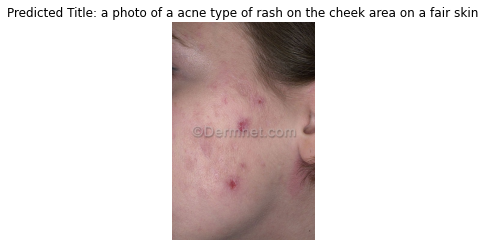

In [66]:
import matplotlib.pyplot as plt

def predict_title(image_input, text_inputs, model):
    with torch.no_grad():
        # Forward pass through the model to get features
        image_features = model.get_image_features(**image_input)
        text_features = model.get_text_features(**text_inputs)

        # Normalize features to compute cosine similarities
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # Compute cosine similarities
        similarities = torch.matmul(text_features, image_features.T).squeeze()
        print(similarities)

        # Determine the index of the highest similarity
        best_title_idx = similarities.argmax()
        print(best_title_idx)
    return best_title_idx

# Prepare inputs
image_path = "images/test/Acne and Rosacea Photos/acne-excoriated-2.jpg"
possible_titles = ["a photo of a tinea type rash at the beard area on a fair skin",
    "a photo of a tinea type rash at the back area on a fair skin",
    "a photo of a tinea type rash at the hand area on a fair skin",
    "a photo of a tinea type rash at the lower leg area on a fair skin",
    "a photo of a tinea type rash at the foot area on a fair skin",
    "a photo of a tinea type rash at the chest area on a fair skin",
    "a photo of a tinea type rash at the facial area on a fair skin",
    "a photo of a tinea type rash at the back of the neck area on a fair skin",
    "a photo of a tinea type rash between the toes area on a fair skin",
    "a photo of a tinea type rash around the ear area on a fair skin",
    "a photo of a tinea type rash at the facial area on a brown skin",
    "a photo of a tinea type rash at the palm area on a brown skin",
    "a photo of a tinea type rash between the toes area on a brown skin",
    "a photo of a acne type of rash on the cheek area on a fair skin"           
    ]
image_input, text_inputs = prepare_inputs(image_path, possible_titles, processor, device)

# Perform inference
best_title_idx = predict_title(image_input, text_inputs, model)
print(best_title_idx)
predicted_title = possible_titles[best_title_idx]
print(predicted_title)

# Visualize the image and print the predicted title
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.title(f"Predicted Title: {predicted_title}")
plt.axis('off')  # Hide axes
plt.show()